## TITLE:


BONUS:
- make a gif of the simulation
- make a slicer for the dt
- make a slicer for the particle and plot position, velocity and acceleration of that particle


## Dynamics

In [1]:
import sys
sys.path.append('./modules')
from tqdm import tqdm as progress

from modules import state
from modules import plot

import numpy as np
from matplotlib import pyplot as plt

In [56]:
CONSTANTS = {
    'DT': 0.005,
    'MAX_DISTANCE' : 6, # angstrom
    'TOTAL_PARTICLES' : 2,
    'MAX_TIME_STEPS' : 100000,
    'MASS' : 39.95,  # argon amu
    'TEMPERATURE' : 300,  # K
    'EPSILON' : 0.0105, # eV
    'SIGMA' : 3.44,  # angstrom
    'CUTOFF' : 1000  # angstrom
}


sample, energies = state.init(CONSTANTS)

for time in progress(range(CONSTANTS['MAX_TIME_STEPS'])):

    current_state  = state.get(sample, CONSTANTS)
    current_state = state.collisions(current_state, CONSTANTS)
    
    state.update(sample, current_state, energies, CONSTANTS)

100%|██████████| 100000/100000 [00:09<00:00, 10986.33it/s]


## Plots

In [53]:
def lj_potential(positions, epsilon, sigma):
    for n, position in enumerate(positions):
        positions[n] = 0.9*sigma if position < 0.9*sigma else position
    return [
        4*epsilon*((sigma/position)**12 - (sigma/position)**6)
        for position in positions
    ]

def lj_force(positions, epsilon, sigma):
    for n, position in enumerate(positions):
        positions[n] = 0.9*sigma if position < 0.9*sigma else position
    return [
        24*epsilon*((sigma**6)/(position**13))*(position**6 - 2*sigma**6)
        for position in positions
    ]

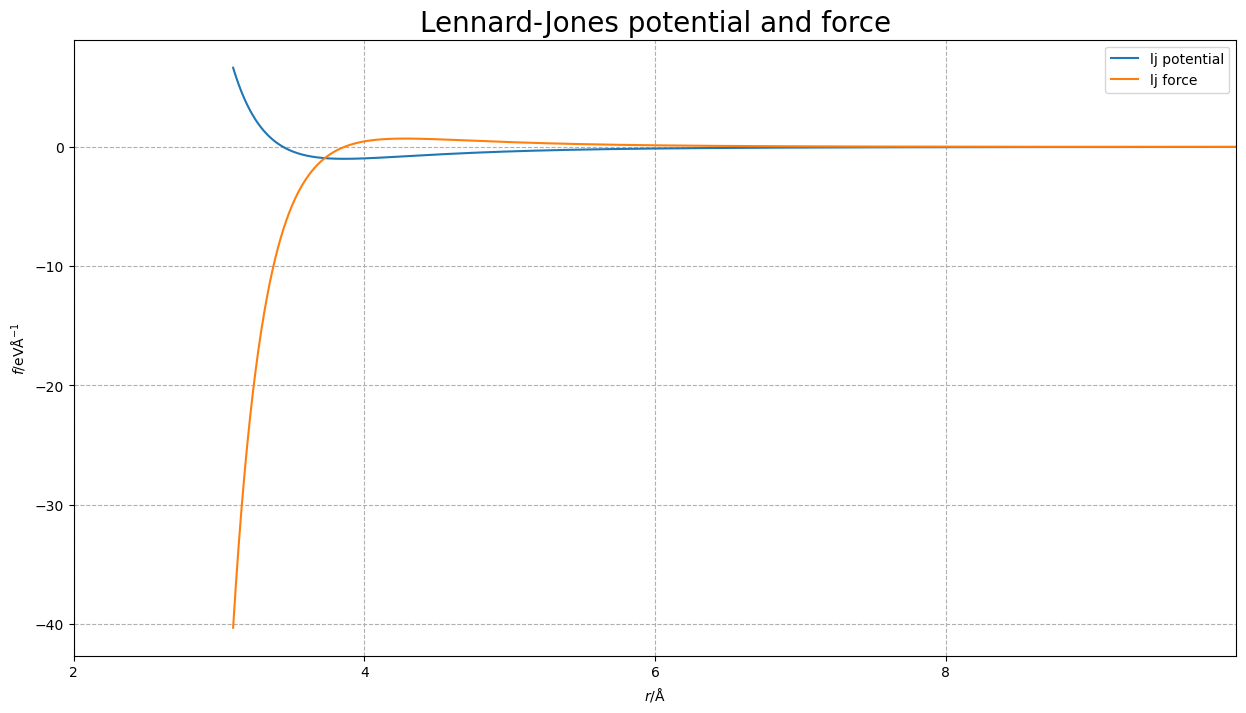

In [54]:
r = np.linspace(-3.2, 29, 10000)
plt.figure(figsize=(15,8))
plt.plot(r, lj_potential(r, CONSTANTS['EPSILON'], CONSTANTS['SIGMA']), label='lj potential')
plt.plot(r, lj_force(r, CONSTANTS['EPSILON'], CONSTANTS['SIGMA']), label='lj force')
# plt.scatter(CONSTANTS['SIGMA'], 0, c='r')
plt.legend()
plt.title('Lennard-Jones potential and force', fontsize=20)
plt.grid(linestyle='--')
plt.xlim(2, 10)
plt.xticks(np.arange(2, 10, 2))
plt.xlabel(r'$r$/Å')
plt.ylabel(r'$f$/eVÅ$^{-1}$')
plt.show()

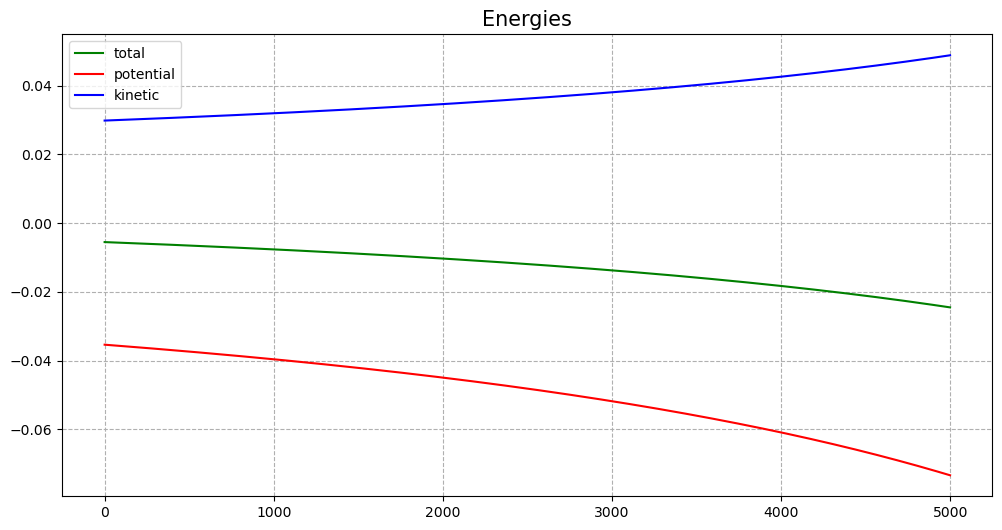

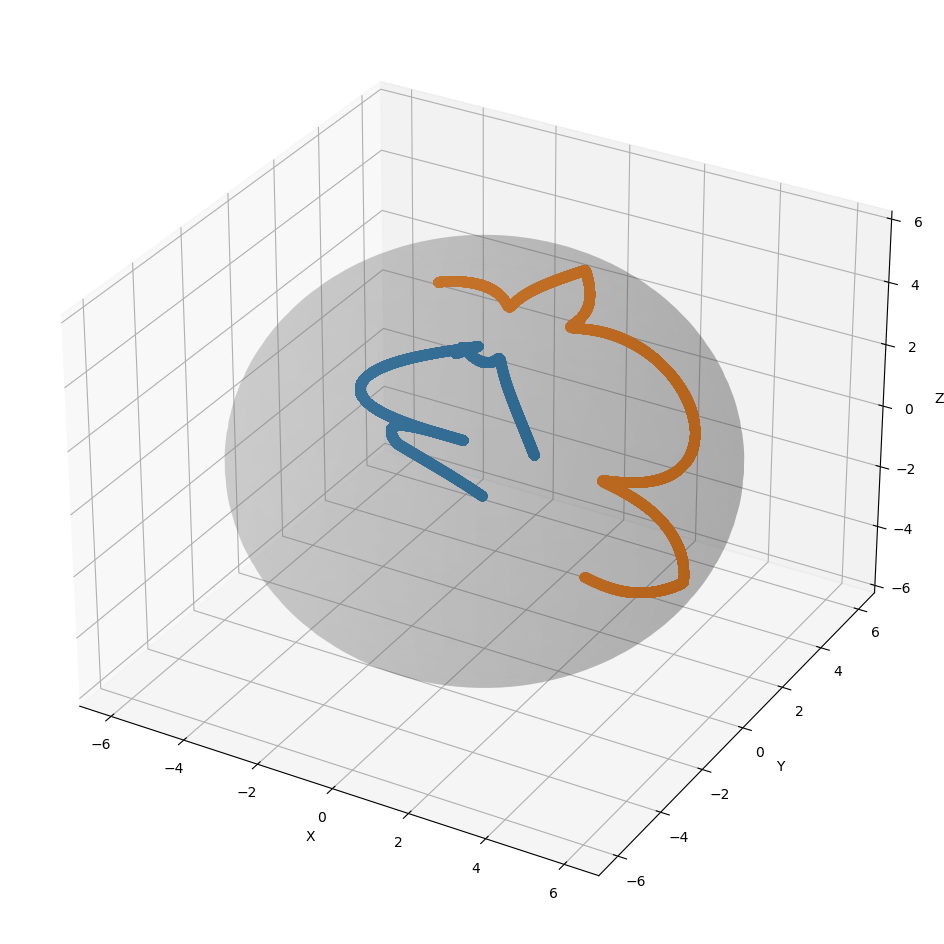

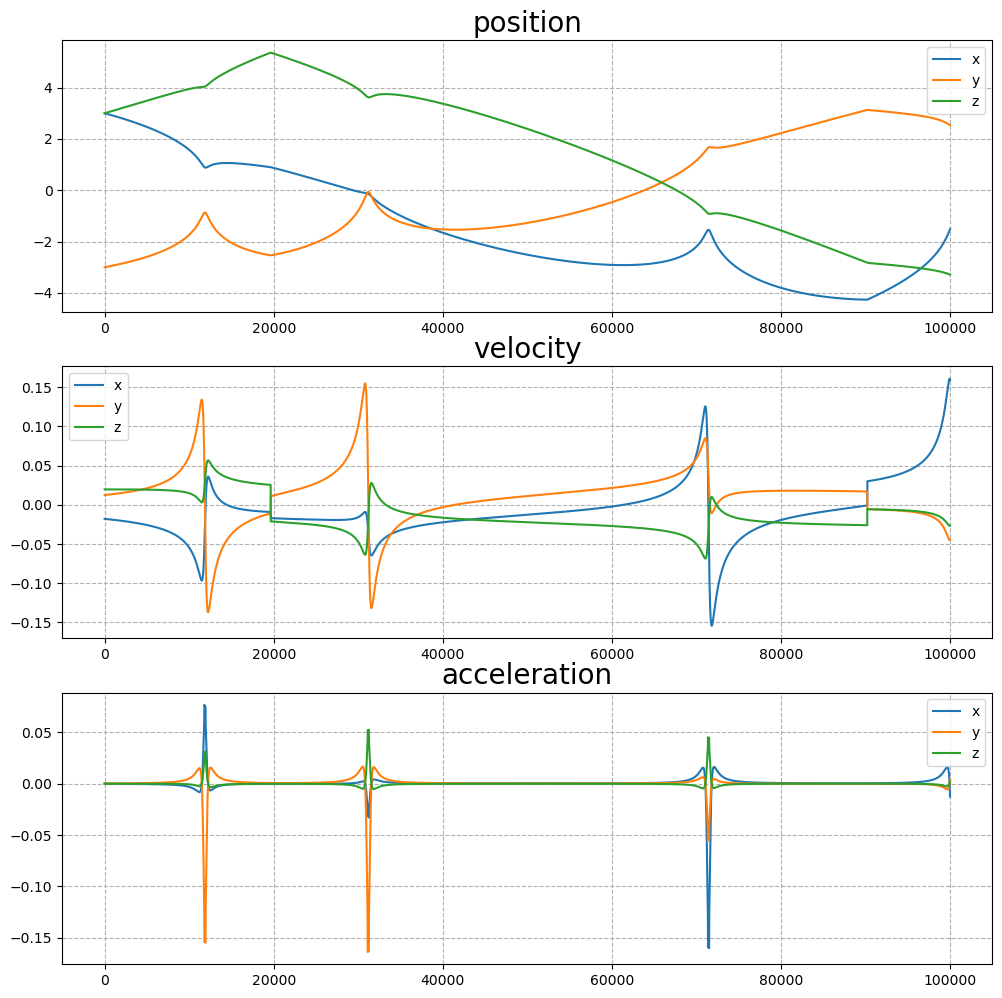

In [55]:
plot.energy(energies)
plot.particle_trajectory(sample, CONSTANTS['MAX_DISTANCE'])
plot.dynamic(sample, 0)